In [33]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import LMC
import archinfo
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random
import math

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

from KDEpy import FFTKDE

pi = np.pi
BIGG = 6.67E-11   #use these constants
MSUN = 1.989e30
MEARTH = 5.972e24
MJUPITER = 1.898e27     #these are all SI units
RJUPITER = 69911e3      #except the periods, which are in days
REARTH = 6371e3         
PJUPITER = 4332.59
PEARTH = 365

In [34]:
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/exoarchive_ipac_confirmed_200507.csv'  #reading in file

raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[77]
VALUES = raw_data[78:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return arr

In [35]:
d = {}
d['starname'] = get_key('pl_hostname')

d['period'] = get_key('pl_orbper')                           #extract periods of planets (days)
if get_key('pl_orbpererr1') > get_key('pl_orbpererr2'):
    d['period_err'] = get_key('pl_orbpererr1')
else:
    d['period_err'] = get_key('pl_orbpererr2')
    

d['radius'] = get_key('pl_radj')                             #extract radius of planets (Jupiter radius)
if get_key('pl_radjerr1') > get_key('pl_radjerr2'):
    d['radius_err'] = get_key('pl_radjerr1')
else:
    d['radius_err'] = get_key('pl_radjerr2')

d['mp'] = get_key('pl_bmassj')                               #read in planet mass (in Jupiter masses)
if get_key('pl_bmassjerr1') > get_key('pl_bmassjerr2'):
    d['mp_err'] = get_key('pl_bmassjerr1')                                
else:                                                                  
    d['mp_err'] = get_key('pl_bmassjerr2')                   #choose whatever error is higher for each of these if statements 
    
d['method'] = get_key('pl_discmethod')

d0 = d.copy()

In [36]:
def check_errors(value, arr, error):
    '''
    value - some measurable value (float)
    arr - some array of the same measurable quantity as value (float array)
    error - the error in that measurable quantity (float)
    
    This function takes a value and determines if it's "normal"; 
    i.e. not crazy when compared to the rest of the array or its error.
    '''                                         #error below 10% of value
    if abs(value-np.mean(arr))/np.std(arr) < 3:           #must be within 3 standard deviations of the mean
        if value > 0:                                     #period, mass, and radius must all be positive
            return False
    return True

In [37]:
def is_number(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

p = d['period']
p_err = d['period_err']
r = d['radius']               #simplifying these arrays so I don't have to type out
r_err = d['radius_err']       #their full names
m = d['mp']
m_err = d['mp_err']
method = d['method']

In [38]:
M = []
M_err = []
P_err = []
P = []
METHOD = []
for i in range(len(m)):
    if is_number(m[i]):
        if is_number(p[i]):                  #make sure all of these have a value
            if is_number(m_err[i]):          #excluding all entries with ''
                if is_number(p_err[i]):
                    M.append(m[i])
                    P.append(p[i])
                    M_err.append(m_err[i])
                    P_err.append(p_err[i])
                    METHOD.append(method[i])
M_final = []
P_final = []
method_final = []
M = np.array(M).astype(np.float)
P = np.array(P).astype(np.float)
M_err = np.array(M_err).astype(np.float)
P_err = np.array(P_err).astype(np.float)
for i in range(len(M)):
    if check_errors(M[i], M, M_err[i]) == False:
        if check_errors(P[i], P, P_err[i]) == False:
            if METHOD[i] != '':
                M_final.append(M[i]*MJUPITER/MEARTH)            #prepping the final array for the scatter plot
                P_final.append(P[i])
                method_final.append(METHOD[i])

In [39]:
def get_filter(arr, string, method = method_final):
    '''
    This obtains the periods, masses, etc. of exoplanets within only
    one detection method (transit, radial velocity, etc.)
    
    arr - numpy array of values, such as periods, masses, etc.
    string - detection method ('Transit', 'Radial Velocity', 'Eclipse Timing Variation')
    '''
    new_list = []
    for i in range(len(arr)):
        if method[i] == string:
            new_list.append(arr[i])
    return np.array(new_list)

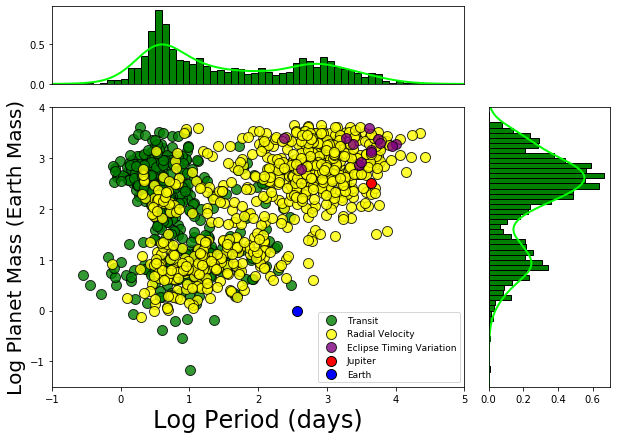

In [55]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

P_transit_filter = get_filter(np.log10(P_final), "Transit")
P_rv_filter = get_filter(np.log10(P_final), "Radial Velocity")
P_eclipse_filter = get_filter(np.log10(P_final), "Eclipse Timing Variations")

M_transit_filter = get_filter(np.log10(M_final), "Transit")
M_rv_filter = get_filter(np.log10(M_final), "Radial Velocity")
M_eclipse_filter = get_filter(np.log10(M_final), "Eclipse Timing Variations")

#mass vs period scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(P_transit_filter, M_transit_filter, c = 'green', edgecolor = 'k', alpha = 0.8, s = 100, label = 'Transit')
ax1.scatter(P_rv_filter, M_rv_filter, c = 'yellow', edgecolor = 'k', alpha = 0.8, s = 100, label = 'Radial Velocity')
ax1.scatter(P_eclipse_filter, M_eclipse_filter, c = 'purple', edgecolor = 'k', alpha = 0.8, s = 100, label = 'Eclipse Timing Variation')
ax1.scatter(math.log10(PJUPITER), math.log10(MJUPITER/MEARTH), c = 'red', edgecolor = 'k', s = 100, label = 'Jupiter')
ax1.scatter(math.log10(PEARTH), math.log10(MEARTH/MEARTH), c = 'blue', edgecolor = 'k', s = 100, label = 'Earth')
ax1.set_xlabel('Log Period (days)', fontsize=24)
ax1.set_ylabel('Log Planet Mass (Earth Mass)', fontsize=20)
ax1.set_xlim(-1, 5)
ax1.set_ylim(-1.5, 4)
ax1.legend(loc = 'lower right', frameon = True, fontsize = 9)

#period histogram
x = np.linspace(-5, 5, 1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.log10(P_final)).evaluate(x)
ax1h = plt.subplot2grid((4,4),(0,0),colspan = 3, rowspan = 1)
ax1h.hist(np.log10(P_final), bins = np.arange(-1, 5, 0.1), density = True, color = 'green', edgecolor = 'k')
ax1h.plot(x, y, lw=2, c = 'lime')
ax1h.set_xlim(-1, 5)
ax1h.set_xticks([])

#mass histogram
x = np.linspace(-5, 5, 1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.log10(M_final)).evaluate(x)
ax2h = plt.subplot2grid((4,4),(1,3),colspan = 1, rowspan = 3)
ax2h.hist(np.log10(M_final), bins = np.arange(-1.5, 4, 0.1), density = True, color = 'green', edgecolor = 'k', orientation = 'horizontal')
ax2h.plot(y, x, lw=2, c = 'lime')
ax2h.set_ylim(-1.5, 4)
ax2h.set_yticks([])




'''
This plots the planet mass on a log scale.  Blue represents Earth, while red represents Jupiter.
Plot designed to resemble that of Winn and Fabrycky (2015).
'''


plt.show()

In [62]:
M = []
M_err = []
R_err = []
R = []
for i in range(len(m)):
    if is_number(m[i]):
        if is_number(r[i]):
            if is_number(m_err[i]):
                if is_number(r_err[i]):
                    M.append(m[i])          #similar process to mass/period above
                    R.append(r[i])          
                    M_err.append(m_err[i])
                    R_err.append(r_err[i])
                    
'''
This has to be a separate piece of code, in my opinion, because
out of mass, radius, and period, a planet could only have two
of these three measurements, but there is no certainty which
measurement is missing.
'''
                    
M_final = []
R_final = []
M_err_final = []
R_err_final = []
M = np.array(M).astype(np.float)
R = np.array(R).astype(np.float)
M_err = np.array(M_err).astype(np.float)
R_err = np.array(R_err).astype(np.float)
for i in range(len(M)):
    if check_errors(M[i], M, M_err[i]) == False:
        if check_errors(R[i], R, R_err[i]) == False:
            M_final.append(M[i]*MJUPITER/MEARTH)             #must be converted into Earth mass/Earth radius
            M_err_final.append(M_err[i]/(M[i]*np.log(10)))  #np.log means natural log 
            R_final.append(R[i]*RJUPITER/REARTH)
            R_err_final.append(R_err[i]/(R[i]*np.log(10)))

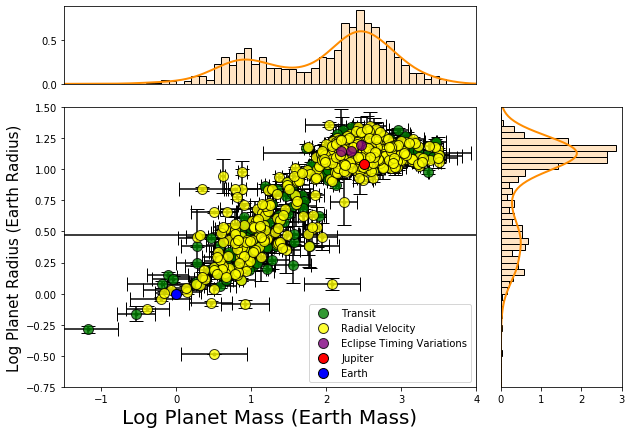

In [128]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

R_transit_filter = get_filter(np.log10(R_final), "Transit")
R_rv_filter = get_filter(np.log10(R_final), "Radial Velocity")
R_eclipse_filter = get_filter(np.log10(R_final), "Eclipse Timing Variations")

M_transit_filter = get_filter(np.log10(M_final), "Transit")
M_rv_filter = get_filter(np.log10(M_final), "Radial Velocity")
M_eclipse_filter = get_filter(np.log10(M_final), "Eclipse Timing Variations")

#radius vs period scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(M_transit_filter, R_transit_filter, c = 'green', edgecolor = 'k', s = 100, label = 'Transit', alpha = 0.8)
ax1.scatter(M_rv_filter, R_rv_filter, c = 'yellow', edgecolor = 'k', s = 100, label = 'Radial Velocity', alpha = 0.8)
ax1.scatter(M_eclipse_filter, R_eclipse_filter, c = 'purple', edgecolor = 'k', s = 100, label = 'Eclipse Timing Variations', alpha = 0.8)
ax1.scatter(math.log10(MJUPITER/MEARTH), math.log10(RJUPITER/REARTH), c = 'red', edgecolor = 'k', s = 100, label = 'Jupiter')
ax1.scatter(math.log10(MEARTH/MEARTH), math.log10(REARTH/REARTH), c = 'blue', edgecolor = 'k', s = 100, label = 'Earth')
ax1.set_xlabel('Log Planet Mass (Earth Mass)', fontsize=20)
ax1.set_ylabel('Log Planet Radius (Earth Radius)', fontsize=15)
ax1.set_xlim(-1.5, 4)
ax1.set_ylim(-0.75, 1.5)
ax1.legend(loc = 'lower right', frameon = True, fontsize = 10)
ax1.errorbar(np.log10(M_final), np.log10(R_final), R_err_final, M_err_final, capsize = 7, fmt = '.k', zorder = 0)

#mass histogram
x = np.linspace(-10, 10, 1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.log10(M_final)).evaluate(x)
ax1h = plt.subplot2grid((4,4),(0,0),colspan = 3, rowspan = 1)
ax1h.hist(np.log10(M_final), bins = np.arange(-1.5, 4, 0.1), density = True, color = 'bisque', edgecolor = 'k')
ax1h.plot(x, y, lw=2, c = 'darkorange')
ax1h.set_xlim(-1.5, 4)
ax1h.set_xticks([])

#radius histogram
x = np.linspace(-5, 5, 1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.log10(R_final)).evaluate(x)
ax2h = plt.subplot2grid((4,4),(1,3),colspan = 1, rowspan = 3)
ax2h.hist(np.log10(R_final), bins = np.arange(-0.75, 1.5, 0.05), density = True, color = 'bisque', edgecolor = 'k', orientation = 'horizontal')
ax2h.plot(y, x, lw=2, c = 'darkorange')
ax2h.set_ylim(-0.75, 1.5)
ax2h.set_yticks([])

'''
Again, blue represents Earth; red represents Jupiter.
'''

plt.show()